In [1]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from jcopml.pipeline import num_pipe, cat_pipe
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from jcopml.pipeline import num_pipe, cat_pipe
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("test_pyspark").getOrCreate()

In [3]:
spark

In [4]:
df = spark.read.csv("data.csv", header=True, inferSchema=True)
df.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [5]:
df.count()

5110

In [6]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



In [7]:
len(df.columns)

12

In [8]:
print(df.groupby('gender').count().show(), df.groupby('hypertension').count().show(), df.groupby('heart_disease').count().show(), df.groupby('ever_married').count().show(), df.groupby('work_type').count().show(), df.groupby('Residence_type').count().show(), df.groupby('smoking_status').count().show(), df.groupby('stroke').count().show())

+------+-----+
|gender|count|
+------+-----+
|Female| 2994|
| Other|    1|
|  Male| 2115|
+------+-----+

+------------+-----+
|hypertension|count|
+------------+-----+
|           1|  498|
|           0| 4612|
+------------+-----+

+-------------+-----+
|heart_disease|count|
+-------------+-----+
|            1|  276|
|            0| 4834|
+-------------+-----+

+------------+-----+
|ever_married|count|
+------------+-----+
|          No| 1757|
|         Yes| 3353|
+------------+-----+

+-------------+-----+
|    work_type|count|
+-------------+-----+
| Never_worked|   22|
|Self-employed|  819|
|      Private| 2925|
|     children|  687|
|     Govt_job|  657|
+-------------+-----+

+--------------+-----+
|Residence_type|count|
+--------------+-----+
|         Urban| 2596|
|         Rural| 2514|
+--------------+-----+

+---------------+-----+
| smoking_status|count|
+---------------+-----+
|         smokes|  789|
|        Unknown| 1544|
|   never smoked| 1892|
|formerly smoked|  885|
+

**6. Buat perintah yang dapat menampilkan statistik data pada setiap kolom**

In [9]:
df.select("age", "avg_glucose_level", "bmi").describe().show()

+-------+------------------+------------------+------------------+
|summary|               age| avg_glucose_level|               bmi|
+-------+------------------+------------------+------------------+
|  count|              5110|              5110|              5110|
|   mean|43.226614481409015|106.14767710371804|28.893236911794673|
| stddev| 22.61264672311348| 45.28356015058193|  7.85406672968016|
|    min|              0.08|             55.12|              10.3|
|    max|              82.0|            271.74|               N/A|
+-------+------------------+------------------+------------------+



In [10]:
df = df[(df.age > 1) & (df.bmi != 'N/A')]

In [11]:
df.select("age", "avg_glucose_level", "bmi").describe().show()

+-------+-----------------+------------------+------------------+
|summary|              age| avg_glucose_level|               bmi|
+-------+-----------------+------------------+------------------+
|  count|             4862|              4862|              4862|
|   mean| 43.2742410530646|105.37412998765909|28.995043192102045|
| stddev|22.27525698343676| 44.53405382197915| 7.815051104692991|
|    min|             1.08|             55.12|              10.3|
|    max|             82.0|            271.74|              97.6|
+-------+-----------------+------------------+------------------+



In [12]:
df.dtypes

[('id', 'int'),
 ('gender', 'string'),
 ('age', 'double'),
 ('hypertension', 'int'),
 ('heart_disease', 'int'),
 ('ever_married', 'string'),
 ('work_type', 'string'),
 ('Residence_type', 'string'),
 ('avg_glucose_level', 'double'),
 ('bmi', 'string'),
 ('smoking_status', 'string'),
 ('stroke', 'int')]

In [13]:
from pyspark.sql.types import DoubleType

df = df.withColumn("bmi",col("bmi").cast(DoubleType())) 

In [14]:
df.dtypes

[('id', 'int'),
 ('gender', 'string'),
 ('age', 'double'),
 ('hypertension', 'int'),
 ('heart_disease', 'int'),
 ('ever_married', 'string'),
 ('work_type', 'string'),
 ('Residence_type', 'string'),
 ('avg_glucose_level', 'double'),
 ('bmi', 'double'),
 ('smoking_status', 'string'),
 ('stroke', 'int')]

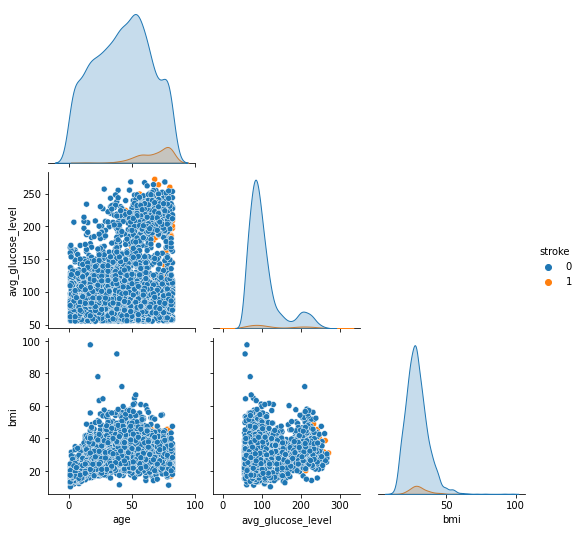

In [15]:
sns.pairplot(hue="stroke", vars=["age", "avg_glucose_level", "bmi"], data = df.toPandas() ,corner=True)

<AxesSubplot:xlabel='stroke', ylabel='age'>

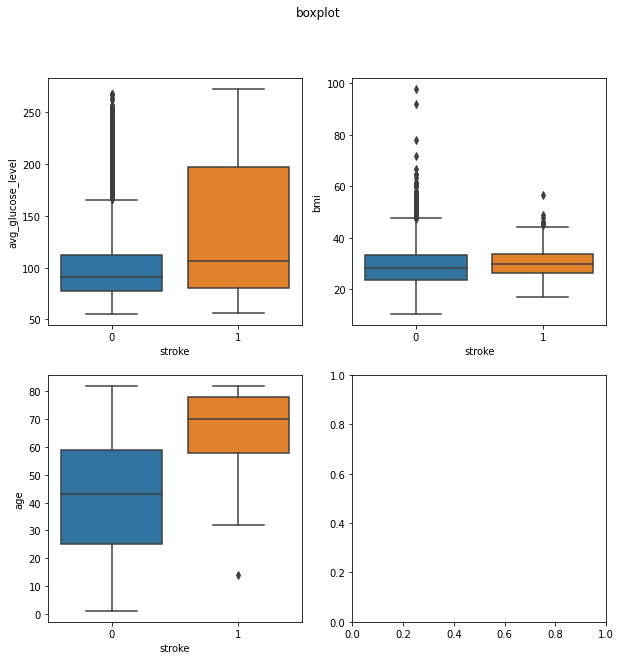

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("boxplot")

#avg_glucose_level
sns.boxplot(x="stroke", y="avg_glucose_level", data=df.toPandas(), ax=axes[0, 0])

#bmi
sns.boxplot(x="stroke", y="bmi", data=df.toPandas(), ax=axes[0, 1])

#age
sns.boxplot(x="stroke", y="age", data=df.toPandas(), ax=axes[1, 0])

<AxesSubplot:xlabel='stroke', ylabel='smoking_status'>

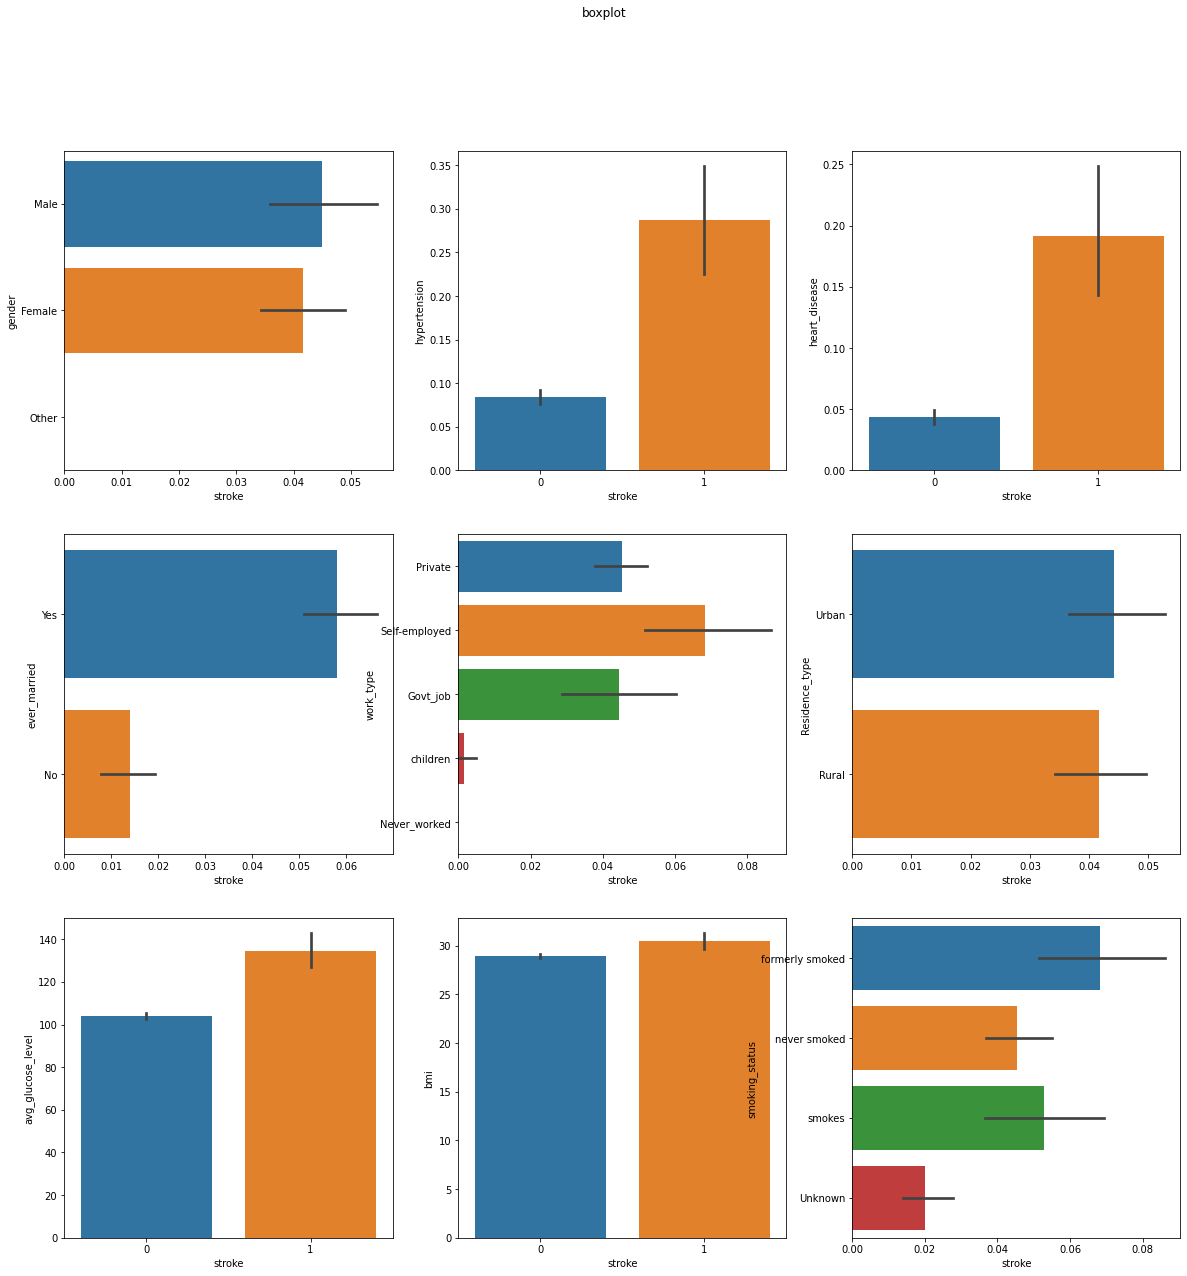

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle("boxplot")

#gender
sns.barplot(x="stroke", y="gender", data=df.toPandas(), ax=axes[0, 0])

#hypertension
sns.barplot(x="stroke", y="hypertension", data=df.toPandas(), ax=axes[0, 1])

#heart_disease
sns.barplot(x="stroke", y="heart_disease", data=df.toPandas(), ax=axes[0, 2])

#ever_married
sns.barplot(x="stroke", y="ever_married", data=df.toPandas(), ax=axes[1, 0])

#work_type
sns.barplot(x="stroke", y="work_type", data=df.toPandas(), ax=axes[1, 1])

#Residence_type
sns.barplot(x="stroke", y="Residence_type", data=df.toPandas(), ax=axes[1, 2])

#avg_glucose_level
sns.barplot(x="stroke", y="avg_glucose_level", data=df.toPandas(), ax=axes[2, 0])

#bmi
sns.barplot(x="stroke", y="bmi", data=df.toPandas(), ax=axes[2, 1])

#smoking_status
sns.barplot(x="stroke", y="smoking_status", data=df.toPandas(), ax=axes[2, 2])

In [18]:
df = df.drop("id")

In [19]:
df.show()

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|24.0|   never smoked|     1|
|  Male|81.0|           0|            0|         Yes|      Private|         Urban|           186.

In [20]:
X = df.drop("stroke").toPandas()
y = df.select("stroke").toPandas()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3889, 10), (973, 10), (3889, 1), (973, 1))

In [21]:
X_train.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object')

In [22]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="standard", transform="yeo-johnson"), ["age", "avg_glucose_level", "bmi"]),
    ('categoric', cat_pipe(encoder='onehot'), ['gender', 'hypertension', 'heart_disease', 'ever_married',
    'work_type', 'Residence_type', 'smoking_status']),
])

from sklearn.linear_model import LogisticRegression
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

model = GridSearchCV(pipeline, gsp.logreg_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))


d:\python\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 14 candidates, totalling 42 fits
{'algo__C': 0.1, 'algo__fit_intercept': False}
0.957315505271278 0.9573156318316091 0.9568345323741008


d:\python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


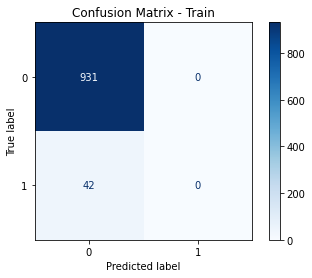

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       931
           1       0.00      0.00      0.00        42

    accuracy                           0.96       973
   macro avg       0.48      0.50      0.49       973
weighted avg       0.92      0.96      0.94       973



d:\python\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
pred_test = model.predict(X_test)
cm_test = confusion_matrix(y_test, pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=model.classes_)
disp.plot(cmap='Blues', include_values=True, values_format='d')
plt.title("Confusion Matrix - Train")
plt.show()

print(classification_report(y_test, pred_test))

In [24]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="standard", transform="yeo-johnson"), ["age", "avg_glucose_level", "bmi"]),
    ('categoric', cat_pipe(encoder='onehot'), ['gender', 'hypertension', 'heart_disease', 'ever_married',
    'work_type', 'Residence_type', 'smoking_status']),
])


pipeline = ImbPipeline([
    ('prep', preprocessor),
    ('imbalance', SMOTE(random_state=42)),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

model = GridSearchCV(pipeline, gsp.logreg_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 14 candidates, totalling 42 fits


d:\python\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")
d:\python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'algo__C': 10.0, 'algo__fit_intercept': True}
0.7503214193880174 0.7480076291917722 0.7482014388489209


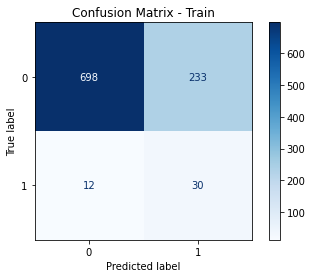

              precision    recall  f1-score   support

           0       0.98      0.75      0.85       931
           1       0.11      0.71      0.20        42

    accuracy                           0.75       973
   macro avg       0.55      0.73      0.52       973
weighted avg       0.95      0.75      0.82       973



In [25]:
pred_test = model.predict(X_test)
cm_test = confusion_matrix(y_test, pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=model.classes_)
disp.plot(cmap='Blues', include_values=True, values_format='d')
plt.title("Confusion Matrix - Train")
plt.show()

print(classification_report(y_test, pred_test))